In [ ]:
%pip install openai
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install matplotlib
%pip install imblearn
%pip install emoji

In [1]:
from openai import OpenAI
import os
import json
def request_hint(word):
    API_KEY = "KEY" #

    client = OpenAI(
        api_key=API_KEY,  
        base_url="https://api.opentyphoon.ai/v1",
    )

    stream = client.chat.completions.create(
        model="typhoon-v1.5x-70b-instruct",
        messages=[
            {
                "role": "system",
                "content": 
                """
                คุณเป็นเจ้าหน้าที่ตรวจสอบคอมเม้นในบริษัทโซเชียลมีเดีย.
                มีหน้าที่ตรวจสอบข้อความและระบุเจตนาหรืออารมณ์ในแต่ละข้อความ,พิจารณาอิโมจิ.
                โดยที่เจตนาบวกแทนด้วยเลข 0, ไม่มีเจตนาหรืออารมณ์แทนด้วยเลข 1,เจตนาลบแทนด้วยเลข 2, และเจตนาถามแทนด้วยเลข 3.
                ให้คุณวิเคราะห์เจตนาหรืออารมณ์ข้อความของ ผู้ใช้งาน และระบุตัวเลขเจตนาตามที่กำหนดไว้.
                โดยคิดอย่างเป็นขั้นตอน.

                ตัวอย่างการวิเคราะห์ข้อความ เจตนา และเหตุผล:
                - เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขันศึก #ช้างเอฟเอคัพ นัดชิงชนะเลิศ => 1 เพราะคอมเม้นนี้สื่ออารมณ์เป็นกลาง
                - (emoji:smiling_face_with_heart-eyes::smiling_face_with_heart-eyes:) => 0 เพราะคอมเม้นนี้สื่อไปในทางรัก
                - บัตรสมาชิกลดได้อีกไหมคับ => 3 เพราะคอมเม้นนี้สื่อไปในการตั้งคำถาม
                - 张丽霞 อ้อออ ผ้าอนามัยแบบสอดอ่ะนะ กุกลัวมาก 5555555 => 2  เพราะคอมเม้นนี้สื่ออารมณ์ความกังวน กลัว
             

                """
            },
            {
                "role": "user",
               # "content": f"ผมอยากฝึกพูดคำว่า {word}"
                "content": f"ลูกค้าคอมเม้นบอกว่า '{word}' มีเจตนาหรืออารมณ์ ตรงกับเลขอะไร (ตอบเฉพาะตัวเลข)"

            }
        ],
        max_tokens=200,
        temperature=0.0,
        top_p=1,
        stream=True,
    )
    output = ""
    for chunk in stream:
        if hasattr(chunk, 'choices') and len(chunk.choices) > 0:
            choice = chunk.choices[0]
            if hasattr(choice, 'delta') and hasattr(choice.delta, 'content'):
                print(choice.delta.content,end="")
                output+=choice.delta.content
 
    return output

ModuleNotFoundError: No module named 'openai'

### PromptV.2 + RAG

In [27]:
import pandas as pd
import re
import emoji
from openai import OpenAI
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load and preprocess the CSV data
data_path = 'data/train.csv'
df = pd.read_csv(data_path)

# Data cleaning and preprocessing functions
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.UNICODE_EMOJI['en'])

# Apply preprocessing to the dataset
df['cleaned_text'] = df['texts'].apply(clean_text)
df['emojis'] = df['texts'].apply(extract_emojis)

# Initialize OpenAI client
API_KEY = "KEY"
client = OpenAI(api_key=API_KEY, base_url="https://api.opentyphoon.ai/v1")

# Create TF-IDF vectorizer for RAG
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])

# Define the RAG function
def classify_sentiment(text, k=3):
    # Preprocess the input text
    cleaned_input = clean_text(text)
    input_emojis = extract_emojis(text)
    
    # Find similar documents
    input_vector = vectorizer.transform([cleaned_input])
    similarities = cosine_similarity(input_vector, tfidf_matrix)[0]
    top_k_indices = similarities.argsort()[-k:][::-1]
    
    # Construct context from similar documents
    context = "\n".join([f"- {df['texts'].iloc[i]}" for i in top_k_indices])
    
    # Define the retrieval and generation prompt
    prompt = f"""
    คุณเป็นผู้เชี่ยวชาญด้านการวิเคราะห์ความรู้สึกในภาษาไทย โดยเฉพาะในบริบทของโซเชียลมีเดีย
    หน้าที่ของคุณคือวิเคราะห์ข้อความและระบุความรู้สึกหรืออารมณ์ในแต่ละข้อความ โดยพิจารณาทั้งเนื้อหา บริบท และอิโมจิ

    กำหนดให้:
    0 = ความรู้สึกเชิงบวก
    1 = ความรู้สึกเป็นกลาง
    2 = ความรู้สึกเชิงลบ
    3 = คำถามหรือการสอบถาม

    คำแนะนำในการวิเคราะห์:
    1. พิจารณาคำศัพท์และสำนวนที่ใช้ในข้อความ
    2. ให้ความสำคัญกับอิโมจิที่ปรากฏ เพราะอาจสื่อความรู้สึกที่ไม่ได้ระบุในข้อความ
    3. สังเกตการใช้ภาษาแบบประชดประชัน หรือการใช้คำที่มีความหมายตรงข้าม
    4. พิจารณาบริบทโดยรวมของข้อความ

    ตัวอย่างการวิเคราะห์:
    - "วันนี้อากาศดีมาก 🌞" => 0 (เชิงบวก เพราะใช้คำว่า "ดีมาก" และมีอิโมจิพระอาทิตย์)
    - "ราคาสินค้าเท่าไหร่ครับ?" => 3 (คำถาม เพราะมีการถามราคาสินค้า)
    - "บริการแย่มาก ไม่มาอีกแล้ว 😡" => 2 (เชิงลบ เพราะใช้คำว่า "แย่มาก" และมีอิโมจิโกรธ)
    - "วันนี้ก็เหมือนทุกวัน ไม่มีอะไรพิเศษ" => 1 (เป็นกลาง เพราะไม่แสดงความรู้สึกทั้งบวกหรือลบ)

    ข้อความที่ต้องวิเคราะห์: "{text}"
    อิโมจิที่พบในข้อความ: "{input_emojis}"

    ข้อความที่มีความคล้ายคลึง (เพื่อเป็นบริบทเพิ่มเติม):
    {context}

    กรุณาวิเคราะห์ความรู้สึกของข้อความข้างต้น และตอบเพียงตัวเลข (0, 1, 2, หรือ 3) ที่ตรงกับความรู้สึกมากที่สุด
    """

    # Make a request to the OpenAI API
    response = client.chat.completions.create(
        model="typhoon-v1.5x-70b-instruct",
        messages=[
            {
                "role": "system",
                "content": prompt
            },
            {
                "role": "user",
                "content": text
            }
        ],
        max_tokens=10,
        temperature=0.2,
        top_p=1,
        stream=False
    )

    # Extract the classification result from the response
    output = response.choices[0].message.content.strip()
    return output

# Apply the RAG model to classify sentiments for each text in the dataset
df['predicted_category'] = df['texts'].apply(classify_sentiment)

# Save the results
output_path = 'data/prediction.csv'
df.to_csv(output_path, index=False)

Evaluate

confusion matrix

accuracy: 46.5 %


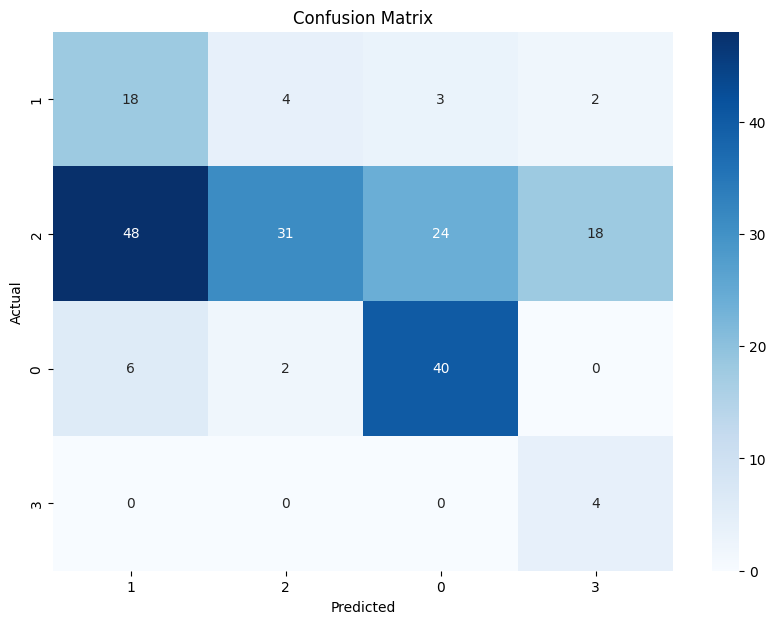

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Read the CSV file
test_df = pd.read_csv("data/prediction.csv")

# Function to calculate accuracy
def get_acc(test_df):
    return len(test_df[test_df['category'] == test_df['predicted_category']]) * 100 / len(test_df)

# Calculate accuracy
accuracy = get_acc(test_df)
print("accuracy:", accuracy, "%")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_df['category'], test_df['predicted_category'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_df['category'].unique(), yticklabels=test_df['category'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Error Analysis (imbalance data)

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report

# Load the data
data_path = 'data/train.csv'
df = pd.read_csv(data_path)

# Split the data into features (X) and target (y)
X = df['texts']  # Assuming 'texts' is the column with your input data
y = df['category']  # Assuming 'category' is your target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Use TF-IDF for feature extraction
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Create and tune the model
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test_tfidf)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 346  253  139   35]
 [ 514 1276  462  107]
 [ 123  257  675   44]
 [   9   33   20   33]]
              precision    recall  f1-score   support

           0       0.35      0.45      0.39       773
           1       0.70      0.54      0.61      2359
           2       0.52      0.61      0.56      1099
           3       0.15      0.35      0.21        95

    accuracy                           0.54      4326
   macro avg       0.43      0.49      0.44      4326
weighted avg       0.58      0.54      0.55      4326



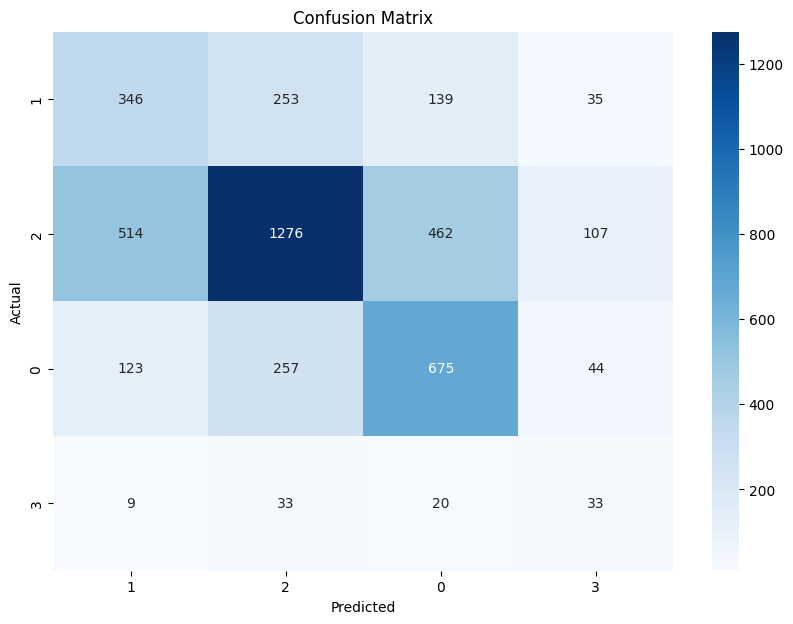

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_df['category'].unique(), yticklabels=test_df['category'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()